In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !cp -arv "/content/drive/My Drive/Colab Notebooks/Data/Airplane" /content

In [ ]:
# !cp -arv "/content/drive/My Drive/Colab Notebooks/Data/Airplanes_Annotations" /content

In [ ]:
#!unzip Images.zip

In [ ]:
#!unzip Airplanes_Annotations.zip

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
import pandas as pd
import os

In [ ]:
path="Images"
annotation="Airplanes_Annotations"

In [ ]:
cv2.setUseOptimized(True)
selective_search=cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [ ]:
image=cv2.imread(os.path.join(path,"42850.jpg"))
print(image.shape)

(256, 256, 3)


Number rectangle: 425


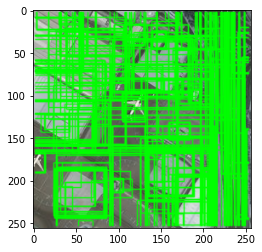

In [ ]:

selective_search.setBaseImage(image)
selective_search.switchToSelectiveSearchFast()
rectangles=selective_search.process()
image_copy=image.copy()
print("Number rectangle:",len(rectangles))
for i,rect in enumerate(rectangles):
  x,y,w,h=rect 
  cv2.rectangle(image_copy,(x,y),(x+w,y+h),(0,255,0),1,cv2.LINE_AA)

plt.imshow(image_copy)


<font size="6"><b>Build data for model</b></font><br>
From the above image, we use it for generate data train

<font size="4"> <b> First of all,we build the intersective over union function</b></font>

In [ ]:
def IOU(boxA,boxB):
  x_left_top=max(boxA['x1'],boxB['x1'])
  y_left_top=max(boxA['y1'],boxB['y1'])
  x_bottom_right=min(boxA['x2'],boxB['x2'])
  y_bottom_right=min(boxA['y2'],boxB['y2'])
  
  if x_left_top>=x_bottom_right or y_left_top>=y_bottom_right:
    return 0
  intersection_area=(x_bottom_right-x_left_top)*(y_bottom_right-y_left_top)
  boxA_area=(boxA['x2']-boxA['x1'])*(boxA['y2']-boxA['y1'])
  boxB_area=(boxB['x2']-boxB['x1'])*(boxB['y2']-boxB['y1'])
  return intersection_area/(boxA_area+boxB_area-intersection_area)  

In [ ]:
train_images=[]
train_labels=[]

<b>A few flags for denoting we completed collect data

In [ ]:
num_positive_class=0
num_negative_class=0
pos_flag=0
nega_flag=0
flag=0

In [ ]:
for e,i in enumerate(os.listdir(annotation)):
    if i.startswith("airplane"):
        filename = i.split(".")[0]+".jpg"
        image = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annotation,i))
        gtvalues=[]
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
        selective_search.setBaseImage(image)
        selective_search.switchToSelectiveSearchFast()
        ssresults = selective_search.process()
        imout = image.copy()
        counter = 0
        falsecounter = 0
        flag = 0
        fflag = 0
        bflag = 0
        for e,result in enumerate(ssresults):
            if e < 2000 and flag == 0:
                for gtval in gtvalues:
                    x,y,w,h = result
                    iou = IOU(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                    if counter < 30:
                        if iou > 0.70:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(1)
                            counter += 1
                    else :
                        fflag =1
                    if falsecounter <30:
                        if iou < 0.3:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(0)
                            falsecounter += 1
                    else :
                        bflag = 1
                if fflag == 1 and bflag == 1:
                    flag = 1
    

In [ ]:
data_train=np.array(train_images)
labels=np.array(train_labels)

In [ ]:
data_train.shape

(30229, 224, 224, 3)

In [ ]:
from keras.layers import Dense
from keras import Model 
from keras import optimizers
from keras.applications.vgg16 import VGG16

In [ ]:
vgg=VGG16(include_top=True,weights='imagenet',input_tensor=None,input_shape=None,pooling=None,
          classes=1000)

In [ ]:
for layer in vgg.layers[:-2]:
  layer.trainable = False
x = vgg.get_layer('fc2')
last_output =  x.output
x = tf.keras.layers.Dense(1,activation = 'sigmoid')(last_output)  
model = tf.keras.Model(vgg.input,x)
model.compile(optimizer = "adam", 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
model.fit(data_train,labels,batch_size = 256,epochs = 3, verbose = 1,validation_split=.05,shuffle = True)


Epoch 1/3
113/113 [==============================] - 241s 2s/step - loss: 0.1643 - acc: 0.9445 - val_loss: 0.1462 - val_acc: 0.9438
Epoch 2/3
113/113 [==============================] - 223s 2s/step - loss: 0.1252 - acc: 0.9556 - val_loss: 0.1410 - val_acc: 0.9530
Epoch 3/3
113/113 [==============================] - 223s 2s/step - loss: 0.1207 - acc: 0.9560 - val_loss: 0.1429 - val_acc: 0.9464


In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/Model/RCNN_airplane_model.h5')